In [8]:
from datetime import date
import os

import geopandas as gpd
import geoplot as gplt
import folium
import mapclassify
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import re
import seaborn as sns
from shapely.geometry import Point, Polygon
from shapely.geometry import MultiPolygon
%matplotlib inline


In [61]:
dataset = pd.read_csv("covidimpact.csv")

In [10]:
dataset.head()

AggregationMethod        Date  Version      AirportName  PercentOfBaseline  \
0             Daily  2020-04-03      1.0  Kingsford Smith                 64   
1             Daily  2020-04-13      1.0  Kingsford Smith                 29   
2             Daily  2020-07-10      1.0  Kingsford Smith                 54   
3             Daily  2020-09-02      1.0  Kingsford Smith                 18   
4             Daily  2020-10-31      1.0  Kingsford Smith                 22   

                                    Centroid    City            State  \
0  POINT(151.180087713813 -33.9459774986125)  Sydney  New South Wales   
1  POINT(151.180087713813 -33.9459774986125)  Sydney  New South Wales   
2  POINT(151.180087713813 -33.9459774986125)  Sydney  New South Wales   
3  POINT(151.180087713813 -33.9459774986125)  Sydney  New South Wales   
4  POINT(151.180087713813 -33.9459774986125)  Sydney  New South Wales   

  ISO_3166_2    Country                                          Geography  
0         AU  Australia  POLYGON((151.164354085922 -33.9301772341877, 1...  
1         AU  Australia  POLYGON((151.164354085922 -33.9301772341877, 1...  
2         AU  Australia  POLYGON((151.164354085922 -33.9301772341877, 1...  
3         AU  Australia  POLYGON((151.164354085922 -33.9301772341877, 1...  
4         AU  Australia  POLYGON((151.164354085922 -33.9301772341877, 1...

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7247 entries, 0 to 7246
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AggregationMethod  7247 non-null   object 
 1   Date               7247 non-null   object 
 2   Version            7247 non-null   float64
 3   AirportName        7247 non-null   object 
 4   PercentOfBaseline  7247 non-null   int64  
 5   Centroid           7247 non-null   object 
 6   City               7247 non-null   object 
 7   State              7247 non-null   object 
 8   ISO_3166_2         7247 non-null   object 
 9   Country            7247 non-null   object 
 10  Geography          7247 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 622.9+ KB


There are no null data.

In [12]:
dataset["Date"] = dataset["Date"].map(lambda x: date.fromisoformat(x))

In [13]:
dataset["weekday"] = dataset["Date"].map(lambda x: x.weekday())
w_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dataset["weekday"] = [w_list[idx] for idx in dataset["weekday"]]

In [14]:
def cut_long(point):
    #point is like 'POINT(151.180087713813 -33.9459774986125)'
    long, _ = point[6:-1].split(" ")
    return float(long)

def cut_lat(point):
    #point is like 'POINT(151.180087713813 -33.9459774986125)'
    _, lat = point[6:-1].split(" ")
    return float(lat)

In [15]:
dataset["long"] = dataset["Centroid"].map(cut_long)
dataset["lat"] = dataset["Centroid"].map(cut_lat)

In [16]:
need_columns = [col for col in dataset.columns if not col in ["AggregationMethod", "Version", "Centroid"]]
dataset = dataset[need_columns]

In [17]:
dataset.head()

Date      AirportName  PercentOfBaseline    City            State  \
0  2020-04-03  Kingsford Smith                 64  Sydney  New South Wales   
1  2020-04-13  Kingsford Smith                 29  Sydney  New South Wales   
2  2020-07-10  Kingsford Smith                 54  Sydney  New South Wales   
3  2020-09-02  Kingsford Smith                 18  Sydney  New South Wales   
4  2020-10-31  Kingsford Smith                 22  Sydney  New South Wales   

  ISO_3166_2    Country                                          Geography  \
0         AU  Australia  POLYGON((151.164354085922 -33.9301772341877, 1...   
1         AU  Australia  POLYGON((151.164354085922 -33.9301772341877, 1...   
2         AU  Australia  POLYGON((151.164354085922 -33.9301772341877, 1...   
3         AU  Australia  POLYGON((151.164354085922 -33.9301772341877, 1...   
4         AU  Australia  POLYGON((151.164354085922 -33.9301772341877, 1...   

  weekday        long        lat  
0     Fri  151.180088 -33.945977  
1     Mon  151.180088 -33.945977  
2     Fri  151.180088 -33.945977  
3     Wed  151.180088 -33.945977  
4     Sat  151.180088 -33.945977

In [18]:
dataset_unique = dataset[~dataset[["AirportName"]].duplicated()].reset_index(drop=True)
dataset_unique

Date                                AirportName  PercentOfBaseline  \
0   2020-04-03                            Kingsford Smith                 64   
1   2020-03-17             Santiago International Airport                 72   
2   2020-04-05                      Calgary International                 65   
3   2020-04-20                     Edmonton International                 46   
4   2020-05-15                    Vancouver International                 68   
5   2020-05-27                     Winnipeg International                100   
6   2020-03-29                      Halifax International                 32   
7   2020-04-10                            Toronto Pearson                 10   
8   2020-08-10                     Hamilton International                100   
9   2020-09-16                           Montreal Mirabel                100   
10  2020-05-04                           Montreal Trudeau                 67   
11  2020-06-22                  Los Angeles International                 63   
12  2020-04-20                San Francisco International                 46   
13  2020-06-14                       Denver International                 30   
14  2020-04-18                       Miami International                  60   
15  2020-04-20  Hartsfield-Jackson Atlanta International                  51   
16  2020-05-16            Daniel K. Inouye International                  73   
17  2020-03-23                Chicago OHare International                 75   
18  2020-04-03                Boston Logan International                  56   
19  2020-04-08         Detroit Metropolitan Wayne County                  49   
20  2020-07-23            Charlotte Douglas International                100   
21  2020-08-07              Newark Liberty International                 100   
22  2020-04-26                     McCarran International                 22   
23  2020-03-16                                  LaGuardia                 95   
24  2020-05-26              John F. Kennedy International                 53   
25  2020-03-21           Dallas/Fort Worth International                  71   
26  2020-06-11           Washington Dulles International                  53   
27  2020-04-14              Seattle-Tacoma International                  62   

                   City              State ISO_3166_2  \
0                Sydney    New South Wales         AU   
1              Santiago  Santiago Province         CL   
2               Calgary            Alberta      CA-AB   
3          Leduc County            Alberta      CA-AB   
4              Richmond   British Columbia      CA-BC   
5              Winnipeg           Manitoba      CA-MB   
6               Halifax        Nova Scotia      CA-NS   
7           Mississauga            Ontario      CA-ON   
8              Hamilton            Ontario      CA-ON   
9               Mirabel             Quebec      CA-QC   
10               Dorval             Quebec      CA-QC   
11          Los Angeles         California      US-CA   
12  South San Francisco         California      US-CA   
13               Denver           Colorado      US-CO   
14        Miami Springs            Florida      US-FL   
15         College Park            Georgia      US-GA   
16       Urban Honolulu             Hawaii      US-HI   
17              Chicago           Illinois      US-IL   
18               Boston      Massachusetts      US-MA   
19              Romulus           Michigan      US-MI   
20            Charlotte     North Carolina      US-NC   
21               Newark         New Jersey      US-NJ   
22             Paradise             Nevada      US-NV   
23             New York           New York      US-NY   
24             New York           New York      US-NY   
25            Grapevine              Texas      US-TX   
26               Floris           Virginia      US-VA   
27               SeaTac         Washington      US-WA   

                           Country 

In [19]:
df_geometry = dataset_unique[['AirportName', 'City', 'State',
                                                     'ISO_3166_2', 'Country', 'long', 'lat']]

In [20]:
def visualize_airport_map(df,  zoom):
    
    lat_map=30.038557
    lon_map=31.231781
    f = folium.Figure(width=1000, height=500)
    m = folium.Map([lat_map,lon_map], zoom_start=zoom).add_to(f)
        
    for i in range(0,len(df)):
        folium.Marker(location=[df["lat"][i],df["long"][i]],icon=folium.Icon(icon_color='white',icon ='plane',prefix='fa')).add_to(m)
        
    return m

In [21]:
visualize_airport_map(dataset_unique, 1)

Text(0.5, 1.0, 'records for each country')

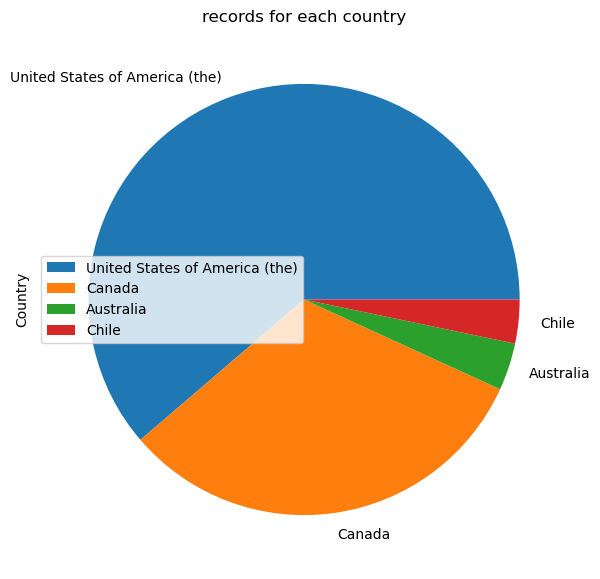

In [22]:
df_Country_count = pd.DataFrame(dataset["Country"].value_counts())
#df_Country_count
g = df_Country_count.plot.pie(y='Country', figsize=(7, 7))
g.set_title("records for each country")

Text(0.5, 1.0, 'records for each airport')

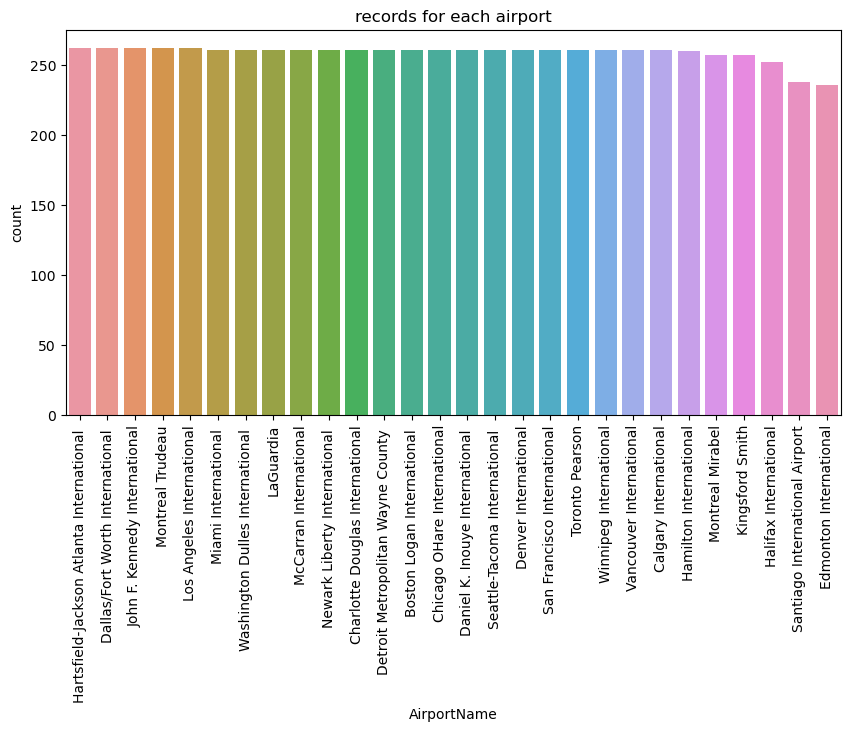

In [23]:
plt.figure(figsize=(10, 5))
g = sns.countplot(data=dataset, x="AirportName",
              order = dataset['AirportName'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("records for each airport")

Text(0.5, 1.0, 'records for each month')

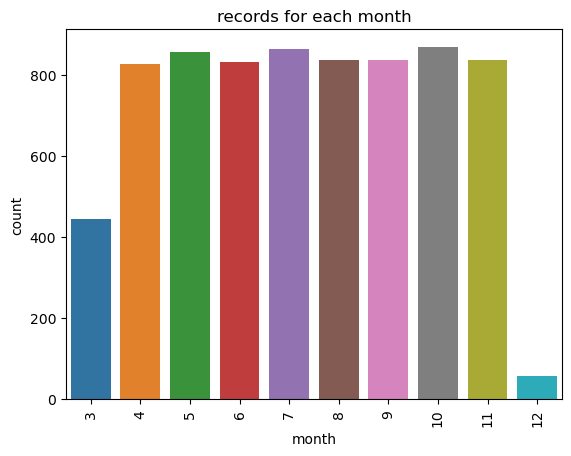

In [24]:
df_month_count = pd.DataFrame(dataset["Date"].map(lambda d: d.month).value_counts())
df_month_count = df_month_count.reset_index()
df_month_count = df_month_count.rename(columns={"Date":"count", "index":"month"})
g = sns.barplot(data=df_month_count.reset_index(), y="count", x="month")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("records for each month")

Text(0.5, 1.0, 'records for each weekday')

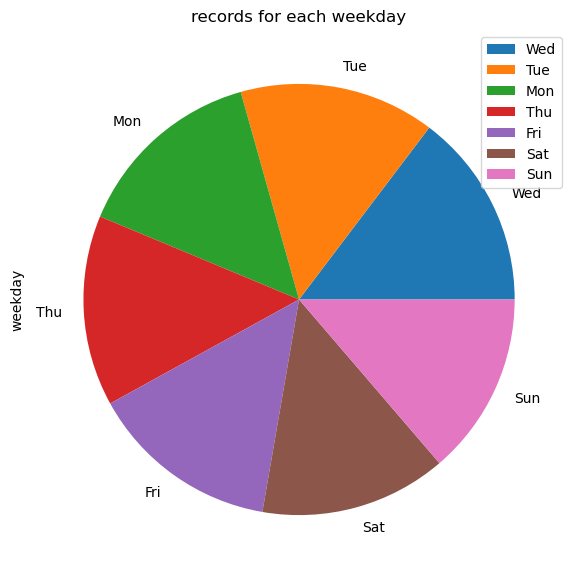

In [25]:
df_weekday_count = pd.DataFrame(dataset["weekday"].value_counts())
g = df_weekday_count.plot.pie(y='weekday', figsize=(7, 7))
g.set_title("records for each weekday")

In [26]:
gdf = gpd.GeoDataFrame(dataset_unique, 
                       geometry=gpd.points_from_xy(dataset_unique.long, dataset_unique.lat))

In [27]:
gdf.head()

Date                     AirportName  PercentOfBaseline  \
0  2020-04-03                 Kingsford Smith                 64   
1  2020-03-17  Santiago International Airport                 72   
2  2020-04-05           Calgary International                 65   
3  2020-04-20          Edmonton International                 46   
4  2020-05-15         Vancouver International                 68   

           City              State ISO_3166_2    Country  \
0        Sydney    New South Wales         AU  Australia   
1      Santiago  Santiago Province         CL      Chile   
2       Calgary            Alberta      CA-AB     Canada   
3  Leduc County            Alberta      CA-AB     Canada   
4      Richmond   British Columbia      CA-BC     Canada   

                                           Geography weekday        long  \
0  POLYGON((151.164354085922 -33.9301772341877, 1...     Fri  151.180088   
1  POLYGON((-70.8043956756592 -33.3719683869737, ...     Tue  -70.794237   
2  POLYGON((-113.981866836548 51.1392131913567, -...     Sun -114.013123   
3  POLYGON((-113.568120002747 53.3110445425655, -...     Mon -113.576261   
4  POLYGON((-123.136525154114 49.1980971490671, -...     Fri -123.177541   

         lat                     geometry  
0 -33.945977  POINT (151.18009 -33.94598)  
1 -33.390727  POINT (-70.79424 -33.39073)  
2  51.118475  POINT (-114.01312 51.11848)  
3  53.308783  POINT (-113.57626 53.30878)  
4  49.193579  POINT (-123.17754 49.19358)

In [28]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1076\913829029.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

Text(0.5, 1.0, 'example world map')

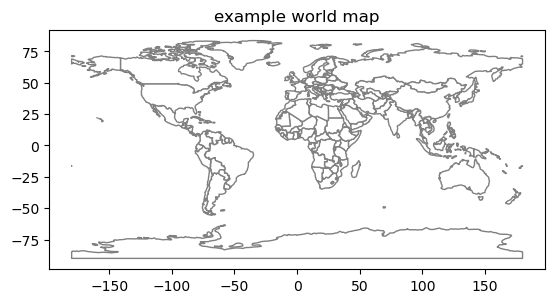

In [29]:
g = world.plot(color='white', edgecolor='gray')
g.set_title("example world map")

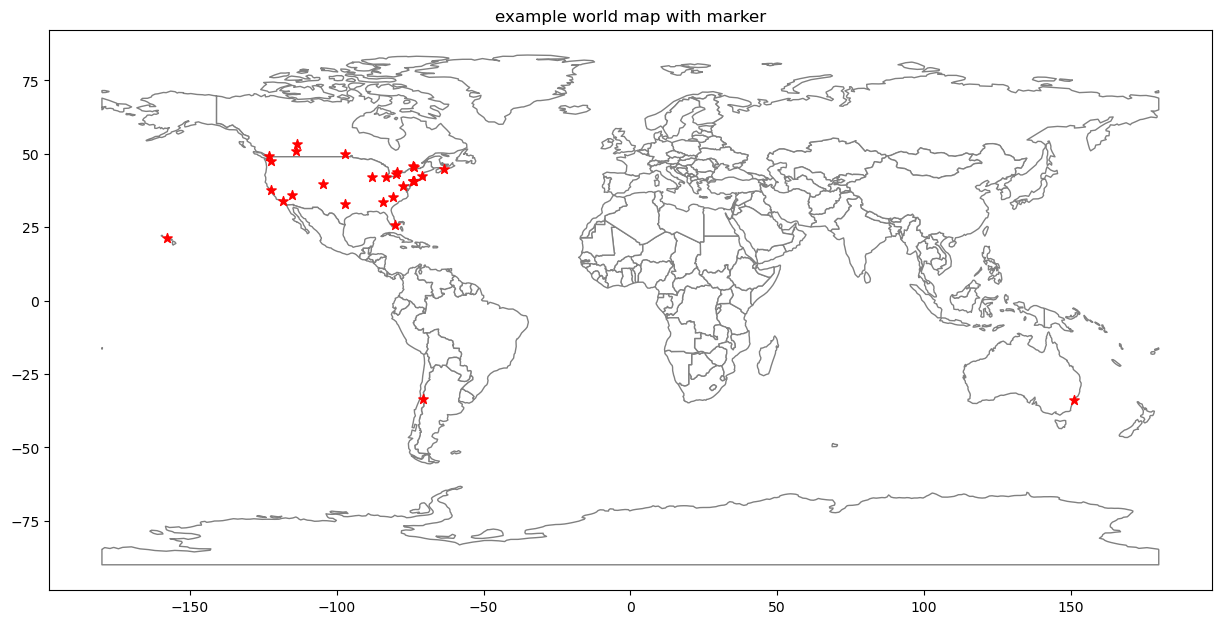

In [30]:
ax = world.plot(color='white', edgecolor='gray', figsize=(15, 10))
g = gdf.plot(ax=ax, marker='*', color='red', markersize=50)
g.set_title("example world map with marker")
plt.show()

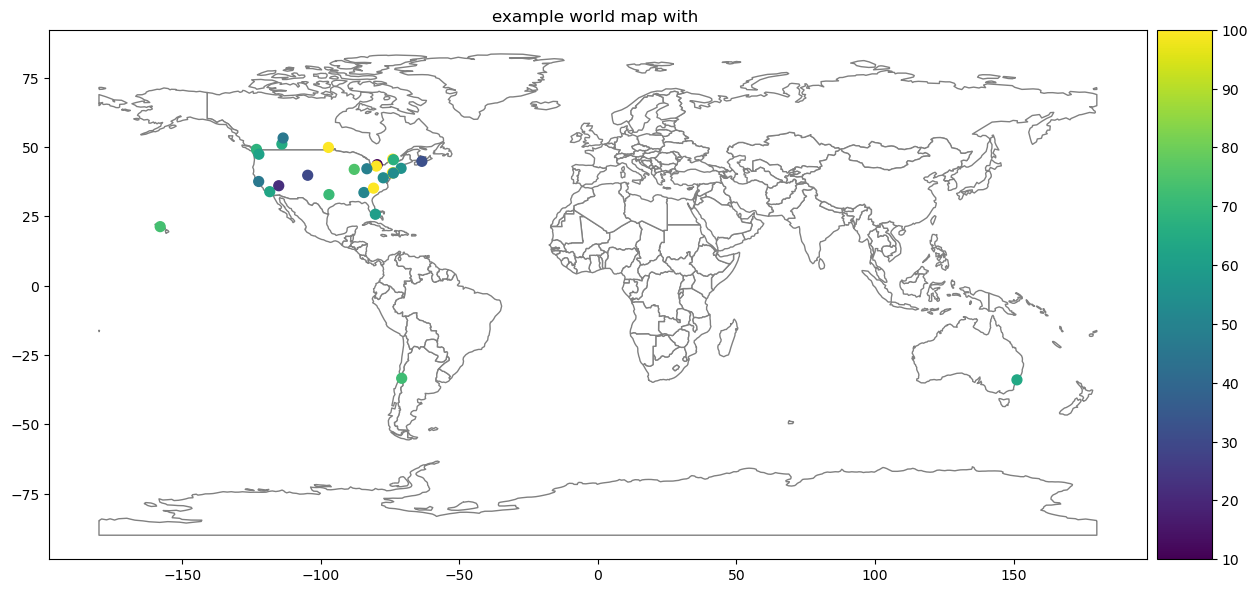

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = gdf.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("example world map with ")
plt.show()

In [32]:
df_airport_weekday_mean = dataset[["AirportName", "weekday", "PercentOfBaseline"]].groupby(["AirportName", "weekday"]).mean()
df_airport_weekday_mean = df_airport_weekday_mean.reset_index()
df_airport_weekday_mean = df_airport_weekday_mean.merge(df_geometry, on="AirportName")

In [33]:
df_airport_weekday_mean.head()

AirportName weekday  PercentOfBaseline    City  \
0  Boston Logan International      Fri          63.567568  Boston   
1  Boston Logan International      Mon          64.162162  Boston   
2  Boston Logan International      Sat          62.432432  Boston   
3  Boston Logan International      Sun          63.351351  Boston   
4  Boston Logan International      Thu          61.432432  Boston   

           State ISO_3166_2                         Country       long  \
0  Massachusetts      US-MA  United States of America (the) -71.010291   
1  Massachusetts      US-MA  United States of America (the) -71.010291   
2  Massachusetts      US-MA  United States of America (the) -71.010291   
3  Massachusetts      US-MA  United States of America (the) -71.010291   
4  Massachusetts      US-MA  United States of America (the) -71.010291   

         lat  
0  42.363633  
1  42.363633  
2  42.363633  
3  42.363633  
4  42.363633

I'll extract only on Sunday's data and create GeoDataFrame.

In [35]:
df_airport_weekday_mean_sun = df_airport_weekday_mean[df_airport_weekday_mean["weekday"]=="Sun"]
gdf_airport_weekday_mean_sun = gpd.GeoDataFrame(df_airport_weekday_mean_sun, 
                                                geometry=gpd.points_from_xy(df_airport_weekday_mean_sun.long, df_airport_weekday_mean_sun.lat))

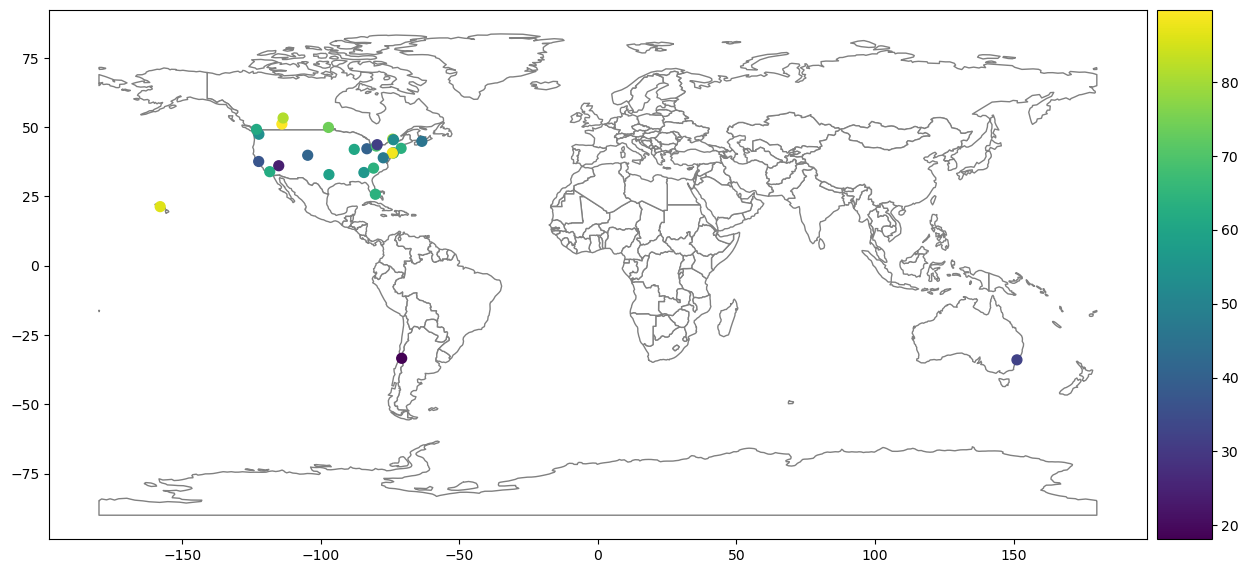

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
gdf_airport_weekday_mean_sun.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
plt.show()

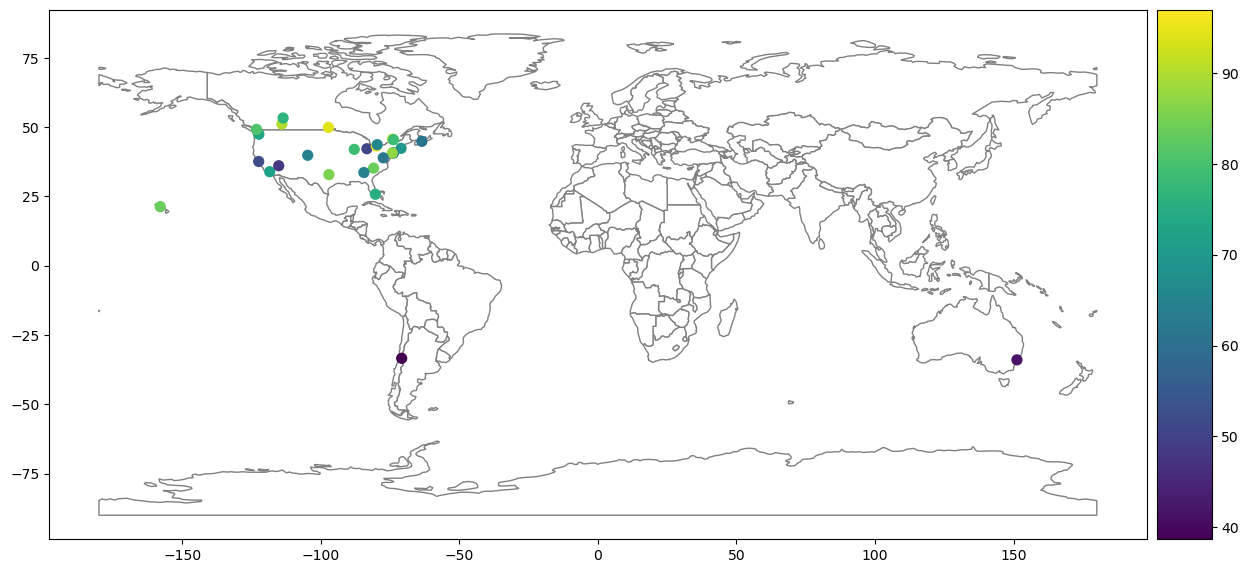

In [37]:
df_airport_weekday_mean_wed = df_airport_weekday_mean[df_airport_weekday_mean["weekday"]=="Wed"]
gdf_airport_weekday_mean_wed = gpd.GeoDataFrame(df_airport_weekday_mean_wed, 
                                                geometry=gpd.points_from_xy(df_airport_weekday_mean_wed.long, df_airport_weekday_mean_wed.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
gdf_airport_weekday_mean_wed.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
plt.show()

In [38]:
df_airport_date_mean = dataset[["AirportName", "Date", "PercentOfBaseline"]]
df_airport_date_mean["Date"] = df_airport_date_mean["Date"].map(lambda d: d.month)
df_airport_date_mean = df_airport_date_mean.groupby(["AirportName", "Date"]).mean()
df_airport_date_mean = df_airport_date_mean.reset_index()
df_airport_date_mean = df_airport_date_mean.merge(df_geometry, on="AirportName")
df_airport_date_mean = df_airport_date_mean.rename(columns={"Date": "month"})

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1076\2011692645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airport_date_mean["Date"] = df_airport_date_mean["Date"].map(lambda d: d.month)


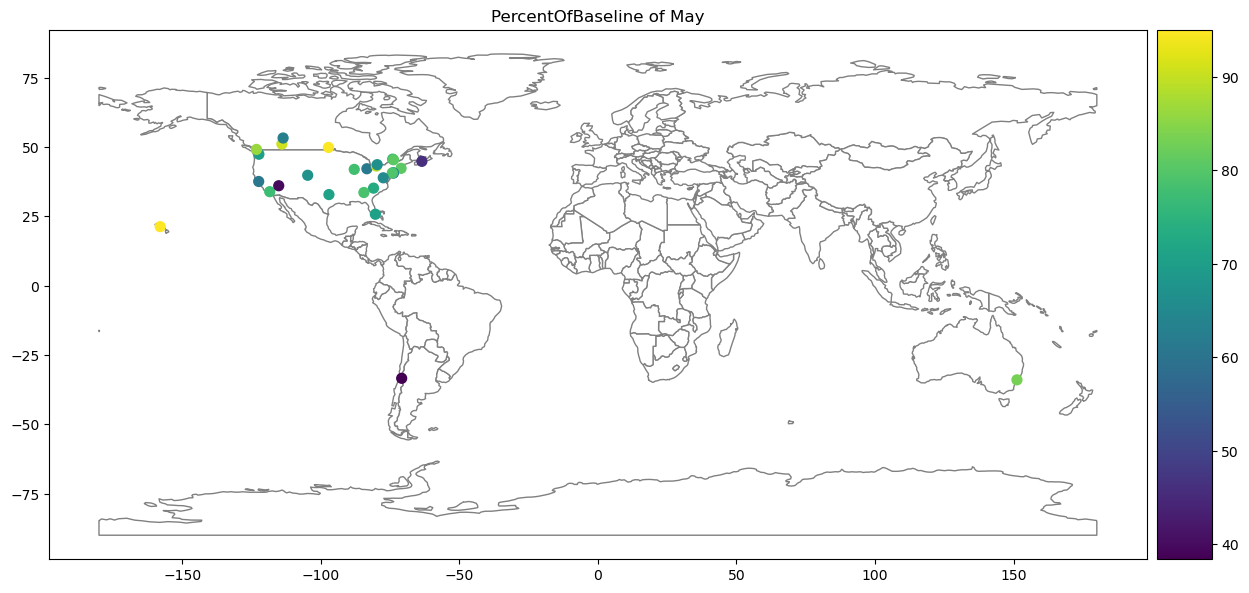

In [39]:
df_airport_date_mean_3 = df_airport_date_mean[df_airport_date_mean["month"]==3]
df_airport_date_mean_3 = gpd.GeoDataFrame(df_airport_date_mean_3, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_3.long, df_airport_date_mean_3.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_3.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of May")
plt.show()

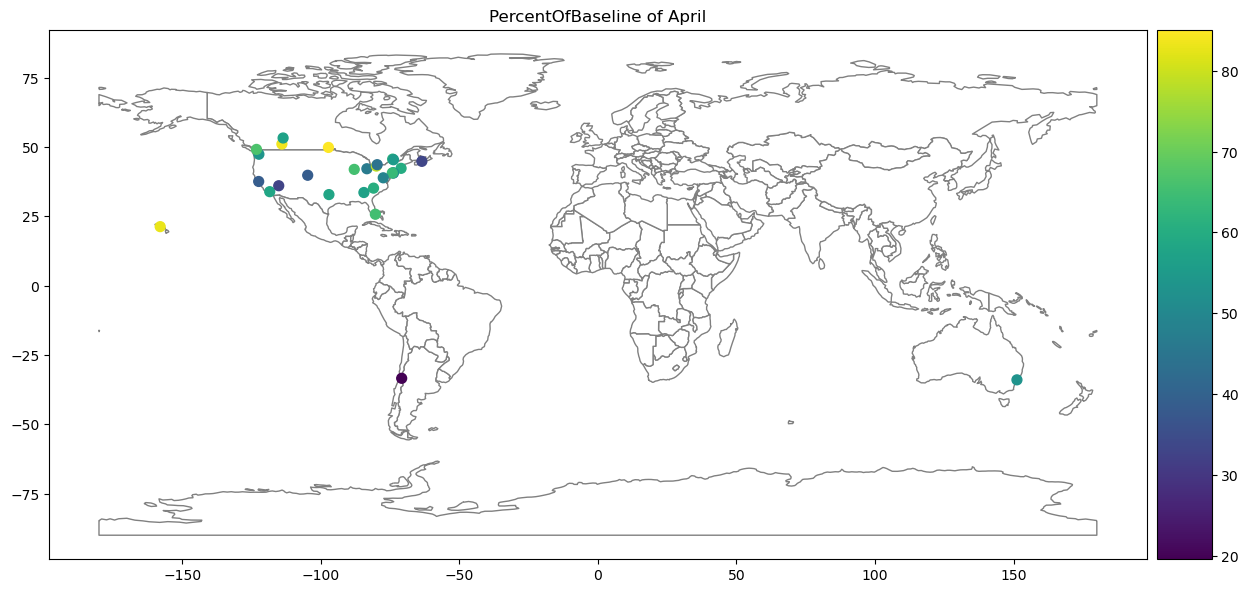

In [40]:
df_airport_date_mean_4 = df_airport_date_mean[df_airport_date_mean["month"]==4]
df_airport_date_mean_4 = gpd.GeoDataFrame(df_airport_date_mean_4, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_4.long, df_airport_date_mean_4.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_4.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of April")
plt.show()

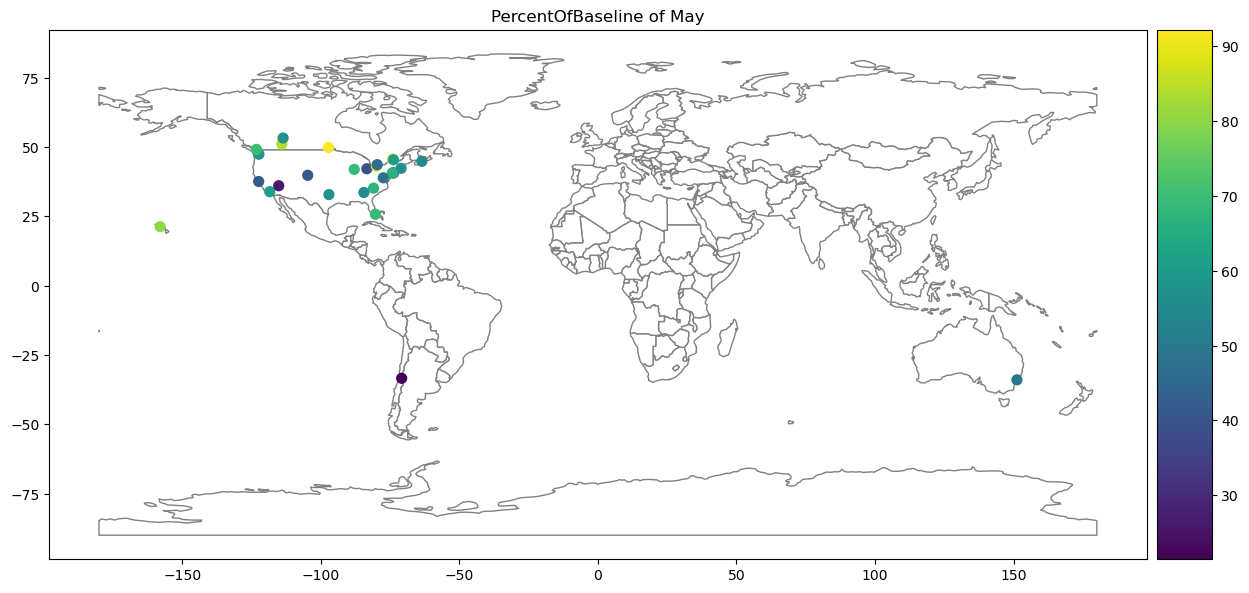

In [41]:
df_airport_date_mean_5 = df_airport_date_mean[df_airport_date_mean["month"]==5]
df_airport_date_mean_5 = gpd.GeoDataFrame(df_airport_date_mean_5, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_5.long, df_airport_date_mean_5.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_5.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of May")
plt.show()

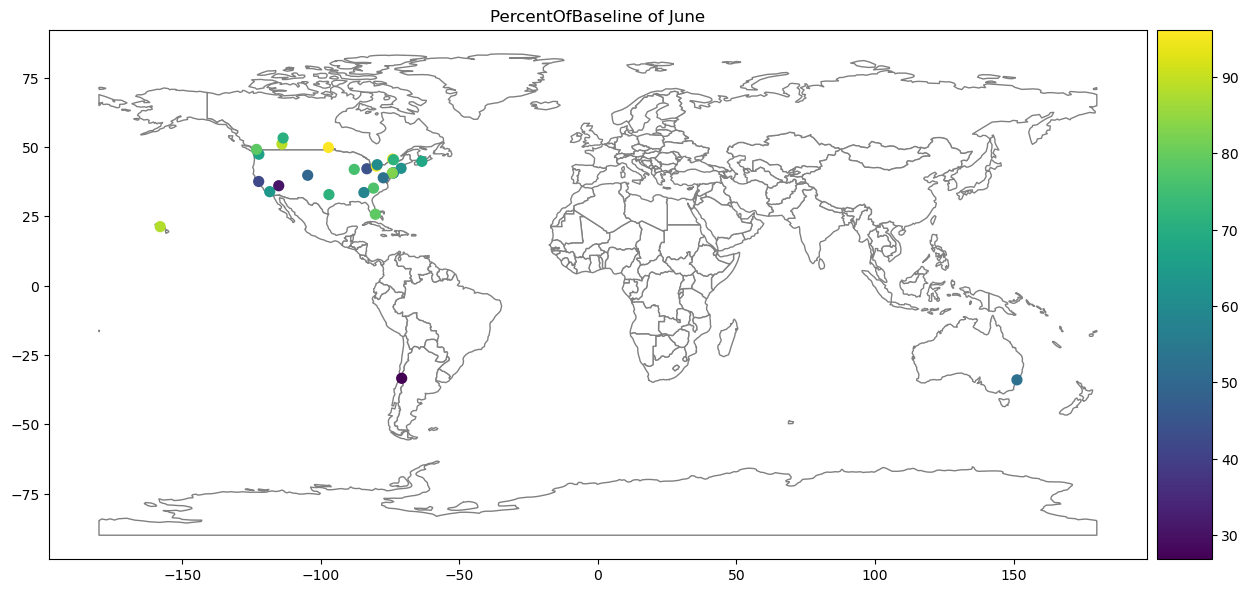

In [42]:
df_airport_date_mean_6 = df_airport_date_mean[df_airport_date_mean["month"]==6]
df_airport_date_mean_6 = gpd.GeoDataFrame(df_airport_date_mean_6, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_6.long, df_airport_date_mean_6.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_6.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of June")
plt.show()

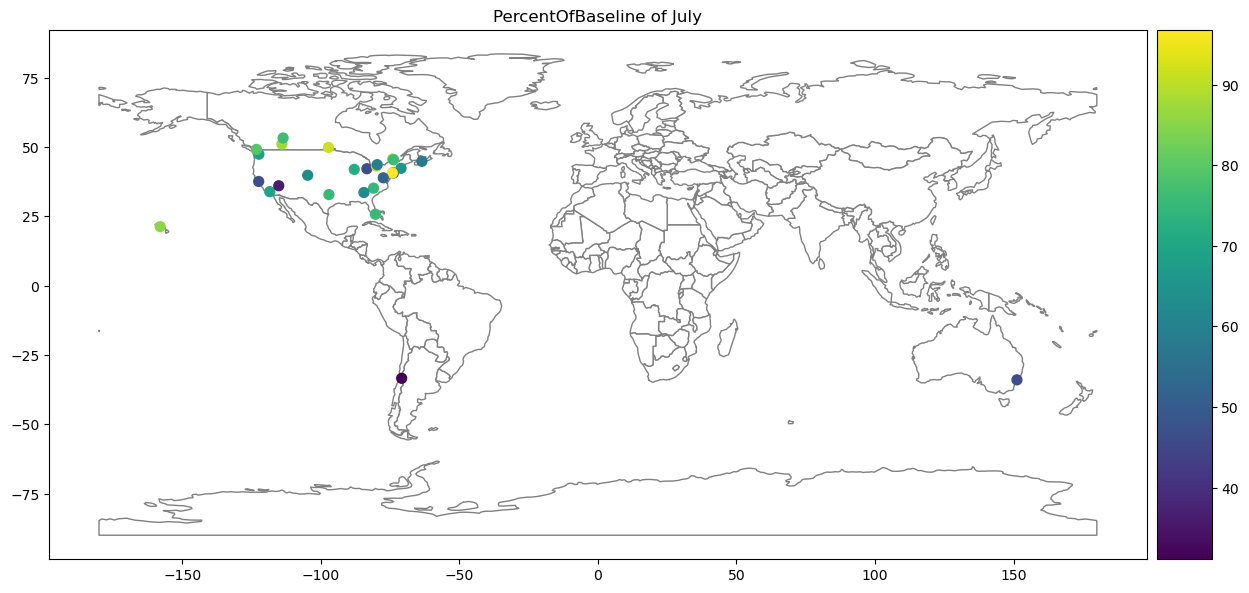

In [43]:
df_airport_date_mean_7 = df_airport_date_mean[df_airport_date_mean["month"]==7]
df_airport_date_mean_7 = gpd.GeoDataFrame(df_airport_date_mean_7, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_7.long, df_airport_date_mean_7.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_7.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of July")
plt.show()

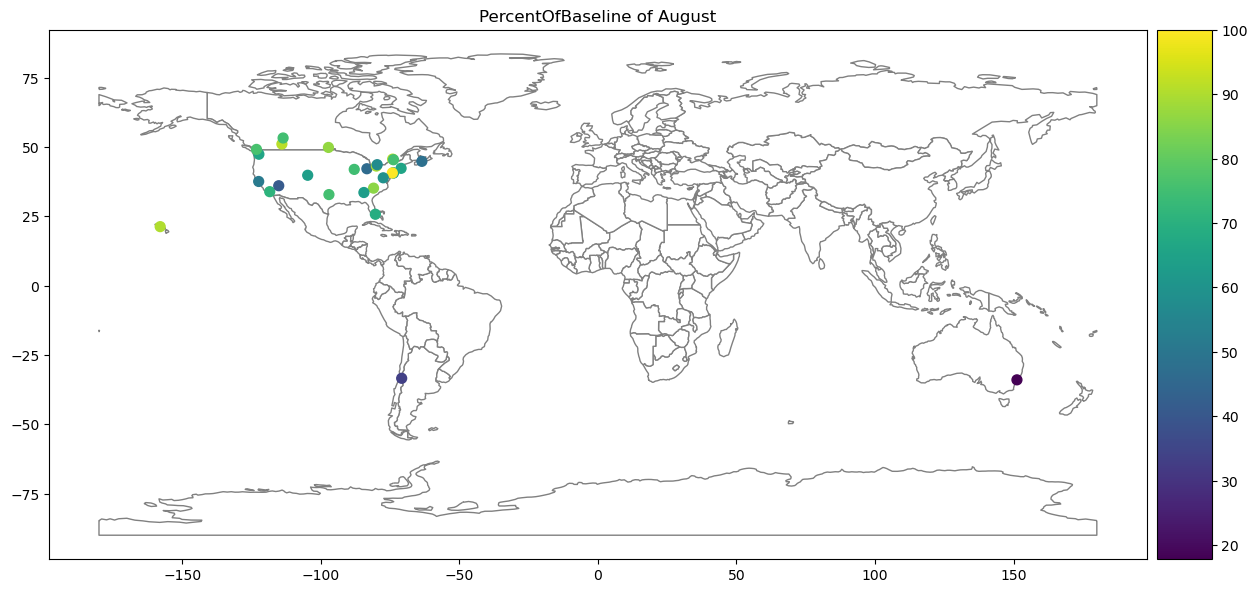

In [44]:
df_airport_date_mean_8 = df_airport_date_mean[df_airport_date_mean["month"]==8]
df_airport_date_mean_8 = gpd.GeoDataFrame(df_airport_date_mean_8, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_8.long, df_airport_date_mean_8.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_8.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of August")
plt.show()

In [45]:
df_airport_date_all_mean = dataset.groupby(["AirportName"]).mean()
df_airport_date_all_mean = df_airport_date_all_mean.reset_index()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1076\491851387.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_airport_date_all_mean = covid_impact_on_airport_traffic.groupby(["AirportName"]).mean()


In [46]:
df_airport_date_all_mean.head()

AirportName  PercentOfBaseline        long        lat
0       Boston Logan International           64.704981  -71.010291  42.363633
1             Calgary International          89.513410 -114.013123  51.118475
2   Charlotte Douglas International          75.375479  -80.947811  35.213689
3       Chicago OHare International          73.084291  -87.910595  41.980460
4  Dallas/Fort Worth International           75.293893  -97.039498  32.894059

In [47]:
fig = px.scatter_mapbox(df_airport_date_all_mean,
                        lat="lat",
                        lon="long",
                        hover_name="AirportName",
                        hover_data=["PercentOfBaseline"],
                        color="PercentOfBaseline",
                        zoom=1,
                        height=600,
                        size="PercentOfBaseline",
                        size_max=30,
                        opacity=0.4,
                        width=1300)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="Mean of trafic on sunday")
fig.show()

In [48]:
fig = px.scatter_mapbox(df_airport_date_all_mean,
                        lat="lat",
                        lon="long",
                        hover_name="AirportName",
                        hover_data=["PercentOfBaseline"],
                        color="PercentOfBaseline",
                        zoom=1,
                        height=600,
                        size="PercentOfBaseline",
                        size_max=30,
                        opacity=0.4,
                        width=1300)
fig.update_layout(mapbox_style='carto-positron')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="Mean of trafic on sunday")
fig.show()

In [49]:
gdf = gdf[[col for col in gdf.columns if col not in ["geometry"]]]
gdf = gdf.rename(columns={'Geography': 'geometry'})

In [50]:
def polygon_str2polygon(polygon_str):
    coodinates = re.split("[, ]", polygon_str[9:-2])
    coodinates = [float(item) for item in coodinates if item != ""]
    return Polygon([coodinates[i:i+2] for i in range(0,len(coodinates),2)])
    
gdf["geometry"] = gdf["geometry"].map(polygon_str2polygon)

In [51]:
gdf_newyork = gdf[gdf["City"].isin(["New York"])]
gdf_newyork = gpd.GeoDataFrame(gdf_newyork)
gdf_newyork

Date                    AirportName  PercentOfBaseline      City  \
23  2020-03-16                      LaGuardia                 95  New York   
24  2020-05-26  John F. Kennedy International                 53  New York   

       State ISO_3166_2                         Country  \
23  New York      US-NY  United States of America (the)   
24  New York      US-NY  United States of America (the)   

                                             geometry weekday       long  \
23  POLYGON ((-73.88763 40.76728, -73.88683 40.767...     Mon -73.873246   
24  POLYGON ((-73.78840 40.62270, -73.78494 40.621...     Tue -73.778447   

          lat  
23  40.773883  
24  40.646027

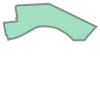

In [52]:
gdf_newyork.iloc[0]["geometry"]

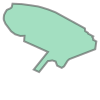

In [53]:
gdf_newyork.iloc[1]["geometry"]

In [54]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
newyork_shape = contiguous_usa[contiguous_usa["state"].isin(["New York"])]
newyork_shape

state adm1_code  population  \
45  New York  USA-3559    19378102   

                                             geometry  
45  POLYGON ((-74.67903 41.35549, -74.84044 41.426...

Text(0.5, 1.0, 'New York')

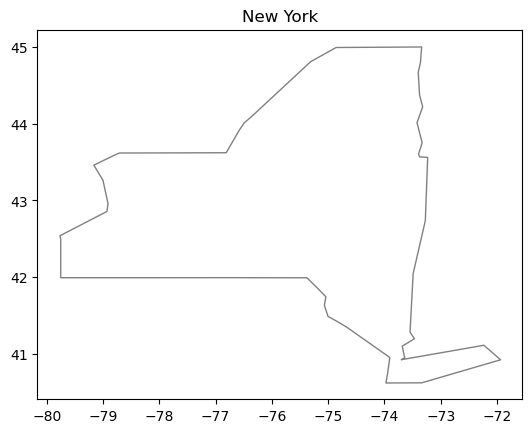

In [55]:
g = newyork_shape.plot(color='white', edgecolor='gray')
g.set_title("New York")

C:\Users\Lenovo\anaconda3\Lib\site-packages\geoplot\geoplot.py:615: UserWarning:

Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.



<Axes: >

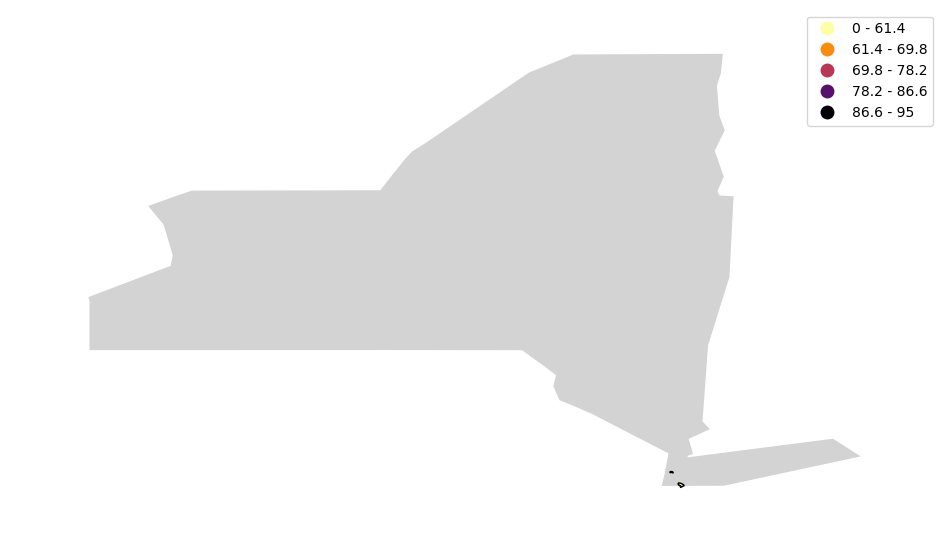

In [56]:
gpd_per_person = gdf_newyork["PercentOfBaseline"]
scheme = mapclassify.Quantiles(gpd_per_person, k=5)

base1 = gplt.choropleth(
    gdf_newyork, #ax=base,
    hue=gpd_per_person, scheme=scheme,
    cmap='inferno_r', legend=True, figsize=(12, 12)
)

gplt.polyplot(
    newyork_shape, ax=base1,
    edgecolor='white',
    facecolor='lightgray',
    figsize=(12, 12)
)

<Axes: >

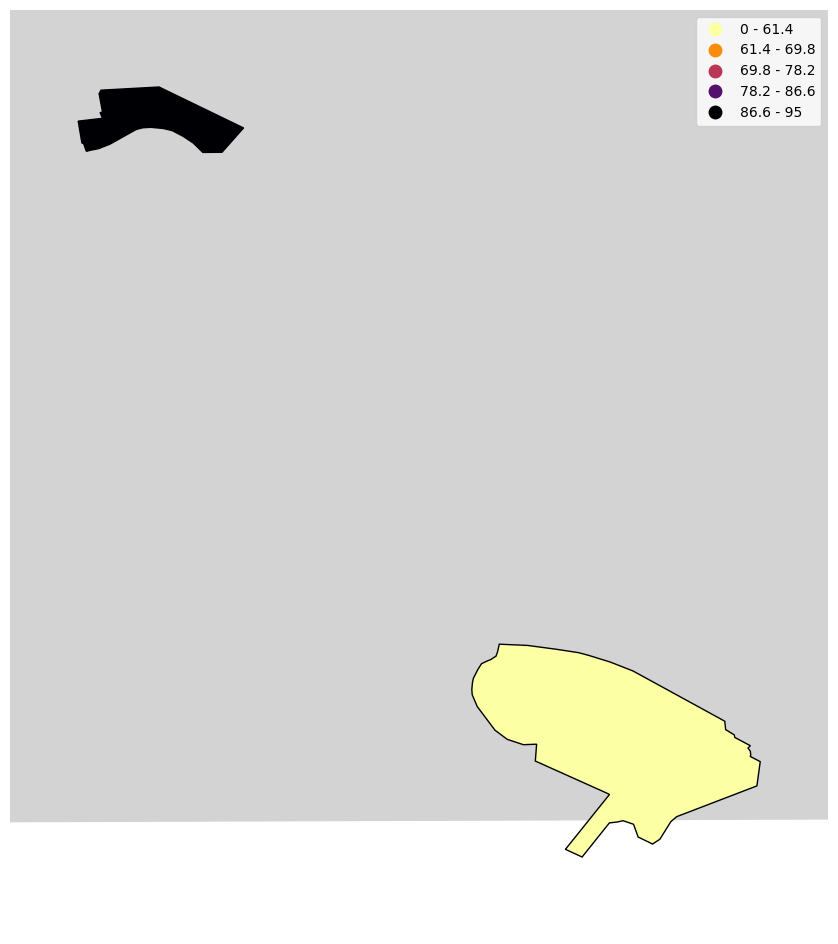

In [57]:
gpd_per_person = gdf_newyork["PercentOfBaseline"]
scheme = mapclassify.Quantiles(gpd_per_person, k=5)

base2 = gplt.polyplot(
    newyork_shape,
    edgecolor='white',
    facecolor='lightgray',
    figsize=(12, 12)
)
gplt.choropleth(
    gdf_newyork, ax=base2,
    hue=gpd_per_person, scheme=scheme,
    cmap='inferno_r', legend=True, figsize=(12, 12)
)

In [58]:
def create_point_geom(data):
    x = data[0]
    y = data[1]
    point = Point(x, y)
    return point

In [59]:
gdf["geometry"] = gdf[["long", "lat"]].apply(create_point_geom, axis=1)